# Item2Vec

We learn good semantic representations for items (products) from transactional data using word2vec. Orders are interpreted as sentences and product as words.

| Description | [See D005 in descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md) |
|:--|:--|
| Dataset | Instacart (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datsets.md)) |
| Papers | Barkan2015, Arora2016 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | Download and unzip the dataset to 'data' folder |
| Libs | Gensim.Word2Vec, Scikit-learn, Pandas, Numpy, Seaborn |

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 8


## Data Loading and Exploration

In [2]:
DATA_PATH = 'data/instacart-market-basket-analysis'
files_list = glob.glob(f'{DATA_PATH}/*.csv')

files_list

['data/instacart-market-basket-analysis/products.csv',
 'data/instacart-market-basket-analysis/orders.csv',
 'data/instacart-market-basket-analysis/order_products__train.csv',
 'data/instacart-market-basket-analysis/departments.csv',
 'data/instacart-market-basket-analysis/aisles.csv',
 'data/instacart-market-basket-analysis/order_products__prior.csv']

In [ ]:
data_dict = {}

for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(null_counts=True))

    print(f'\nSample ({file}):')
    display(HTML(data.sample(min(10, len(data))).to_html()))
    print(f'\nDataset stats ({file}):')
    display(HTML(data.describe().T.to_html()))
    
    print(f'\nColumn stats ({file}):')
    for col in data.columns:
        print(f'\nColumn {col} has {data[col].nunique()} unique values')
        print(f"Example of values: {data[col].unique()[:10]}")

    data_dict[file.split('.')[0].split('/')[-1]] = data
    
data_dict.keys()

## Data Preparation

In [4]:
order_product_cnt_ds = data_dict['order_products__prior'].groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']
order_ds = data_dict['orders'].merge(order_product_cnt_ds, left_on='order_id', right_index=True)      # add product counters to orders

order_ds.info()
order_ds.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3421081
Data columns (total 8 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
product_cnt               int64
dtypes: float64(1), int64(6), object(1)
memory usage: 220.7+ MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_cnt
2913136,1982769,175730,prior,23,1,21,3.0,16
2693228,383139,162209,prior,23,5,11,8.0,23
2594690,2875591,156205,prior,24,2,7,2.0,14
2262852,54261,136259,prior,15,4,9,8.0,4
112466,1334622,6794,prior,12,4,16,21.0,10


## Data Summary

In [5]:
# Helper function to printing large numbers 
def to_readable(v):
    value = round(v,2) if isinstance(v, float) else v
    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000,1)) + 'K'
    elif value >= 1000000:
        return str(round(value/1000000,1)) + 'M'
    return value

total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(data_dict['order_products__prior'])
unique_products = len(data_dict['order_products__prior'].product_id.unique())

print("total user = {}".format(to_readable(total_user)))
print("total order = {} ({} orders per user)".format(to_readable(total_order), to_readable(total_order/total_user) ))
print("total product = ", to_readable(unique_products))
print("total ordered product  = {} ({} orders per product)".format(to_readable(total_ordered_product), to_readable(total_ordered_product/unique_products) ))

total user = 206.2K
total order = 3.2M (15.59 orders per user)
total product =  49.7K
total ordered product  = 32.4M (652.91 orders per product)


We now proceed to learning a good semantic representation for items (products) using word2vec model.

## Item2Vec, Step 1: Prepare a Product Corpus

In [6]:
merge_order_product_ds = data_dict['order_products__prior'].merge(order_ds, on='order_id' )

print('Creating sequences based on transactions...')
order_product_list = merge_order_product_ds\
    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id']]\
    .values.tolist()

# Each entry of a corpus is one order represented by a chronologically sorted sequence of product IDs.
print('Preparing a corpus of items...')
product_corpus = []     
sentence = []
new_order_id = order_product_list[0][0]
for (order_id, product_id) in tqdm(order_product_list):
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

Creating sequences based on transactions...
Preparing a corpus of items...


## Item2Vec, Step 2: Train Word2Vec model

We use implementation from Gensim adjusting the following parameters:
* sentences = product_corpus
* window - maximum distance between the current and predicted word within a sentence.
* size - dimensionality of the word vectors.
* min_count - ignores all words with total frequency lower than this.

In [7]:
TRAIN_ITEM_MODEL = True   # True - create a new model, False - load a previosuly created model
LOGGING_ELABLED = False
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [8]:
from gensim.models import Word2Vec

if LOGGING_ELABLED:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
    
WORD_DIM = 200
model_filename = f'models/item2vec.{WORD_DIM}d.model'
if TRAIN_ITEM_MODEL:
    model = Word2Vec(product_corpus, 
                window=5, 
                size=WORD_DIM, 
                workers=mp.cpu_count() - 2, 
                min_count=100)
    
    model.save(model_filename)
    print(f'Model saved to [{model_filename}]')
    
else:
    model = Word2Vec.load(model_filename)
    print(f'Model loaded from [{model_filename}]')

Model saved to [models/item2vec.200d.model]


In [9]:
def to_product_name(id, columns='product_name'):
    return data_dict['products'][data_dict['products'].product_id==id][columns].values.tolist()[0]

def most_similar_readable(model, product_id, topn=10):
    similar_list = [(product_id, 1.0)] + model.wv.most_similar(str(product_id), topn=topn)
    return pd.DataFrame([( to_product_name(int(id)), int(id), similarity ) for (id, similarity) in similar_list],
                        columns=['product', 'product_id', 'similarity'])

In [10]:
# Reality check: Show the nearest neighbors for several common products 
for product_id in [13176, 39180, 2326]:
    most_similar_readable(model, product_id) 

,product,product_id,similarity
0,Bag of Organic Bananas,13176,1.000000
1,Organic Banana,37067,0.739392
2,Banana,24852,0.717724
3,Organic D'Anjou Pears,22825,0.513500
4,Organic Bosc Pear,46969,0.498546
5,Organic Raspberries,27966,0.479186
6,Organic Bartlett Pear,43122,0.472657
7,Organic Red Bartlett Pear,27925,0.466412
8,Organic Kiwi,39928,0.465133
9,Organic Cripps Pink Apples,40723,0.462228


,product,product_id,similarity
0,Organic Lowfat 1% Milk,39180,1.000000
1,Organic Reduced Fat Milk,38689,0.872450
2,Organic Homestyle Waffles,25753,0.653198
3,Organic Multigrain Waffles,9825,0.652810
4,Organic Yokids Lemonade/Blueberry Variety Pack Yogurt Squeezers Tubes,10761,0.640571
5,Organic Mini Homestyle Waffles,162,0.639609
6,Organic Blueberry Waffles,2326,0.632171
7,Low Fat Vanilla Yogurt,30442,0.621984
8,1% Lowfat Milk,24024,0.620000
9,Organic Whole Milk,27845,0.617360


,product,product_id,similarity
0,Organic Blueberry Waffles,2326,1.000000
1,Organic Homestyle Waffles,25753,0.813507
2,Organic Mini Homestyle Waffles,162,0.789784
3,Organic Multigrain Waffles,9825,0.787700
4,Apple Cinnamon Instant Oatmeal,37464,0.761317
5,Original Veggie Straws,34448,0.747774
6,Ice Cream Sandwiches Vanilla,38274,0.715711
7,Organic Cinnamon Apple Sauce,15995,0.712390
8,Baked Aged White Cheddar Rice and Corn Puffs,3599,0.706393
9,Organic Creamy Peanut Butter,43713,0.702534


## Item2Vec, Step 3: Visualize the Semantic Space Using TSNE

In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

In [43]:
# prepare the embeddings for TSNE
word_vectors = model.wv
vocab = list(model.wv.vocab.keys())
item2vector_dict = {arg:model.wv[arg] for arg in vocab}
X = pd.DataFrame(item2vector_dict).T.values
X.shape, len(vocab), vocab[0]

((11332, 200), 11332, '196')

In [44]:
# perform TSNE
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
tsne = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(distance_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11332 samples in 0.078s...
[t-SNE] Computed neighbors for 11332 samples in 3.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11332
[t-SNE] Computed conditional probabilities for sample 2000 / 11332
[t-SNE] Computed conditional probabilities for sample 3000 / 11332
[t-SNE] Computed conditional probabilities for sample 4000 / 11332
[t-SNE] Computed conditional probabilities for sample 5000 / 11332
[t-SNE] Computed conditional probabilities for sample 6000 / 11332
[t-SNE] Computed conditional probabilities for sample 7000 / 11332
[t-SNE] Computed conditional probabilities for sample 8000 / 11332
[t-SNE] Computed conditional probabilities for sample 9000 / 11332
[t-SNE] Computed conditional probabilities for sample 10000 / 11332
[t-SNE] Computed conditional probabilities for sample 11000 / 11332
[t-SNE] Computed conditional probabilities for sample 11332 / 11332
[t-SNE] Mean sigma: 0.153508
[t-SNE] KL divergence

In [50]:
df_semantic_item = pd.DataFrame({'product_id': vocab})
df_semantic_item['tsne-2d-one'] = tsne_results[:,0]
df_semantic_item['tsne-2d-two'] = tsne_results[:,1]
df_semantic_item['product_id'] = df_semantic_item['product_id'].astype(int)

df_semantic_item = df_semantic_item.merge(data_dict['products'], on='product_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['aisles'], on='aisle_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['departments'], on='department_id', how='left')

df_semantic_item.sample(5)

,product_id,tsne-2d-one,tsne-2d-two,product_name,aisle_id,department_id,aisle,department
8114,36149,22.190212,-27.754969,Beast Burger,42,1,frozen vegan vegetarian,frozen
8509,7376,-29.391506,24.876825,Stainlifters Small & Mighty Super Concentrated Liquid Laundry Detergent,75,17,laundry,household
826,35855,6.374580,-26.509451,Unbleached All-Purpose Flour,17,13,baking ingredients,pantry
6145,21635,-11.942523,0.140718,Turkey Fully Cooked Breakfast Sausage 12 Links,106,12,hot dogs bacon sausage,meat seafood
6923,21225,-5.408972,12.697894,Honey Bunches With Almonds Cereal,121,14,cereal,breakfast


In [51]:
n_aisle = df_semantic_item['aisle'].nunique()
n_department = df_semantic_item['department'].nunique()
print(f"Unique aisles: {n_aisle}") 
print(f"Unique departments: {n_department}")

Unique aisles: 134
Unique departments: 21


<Figure size 1152x1152 with 0 Axes>

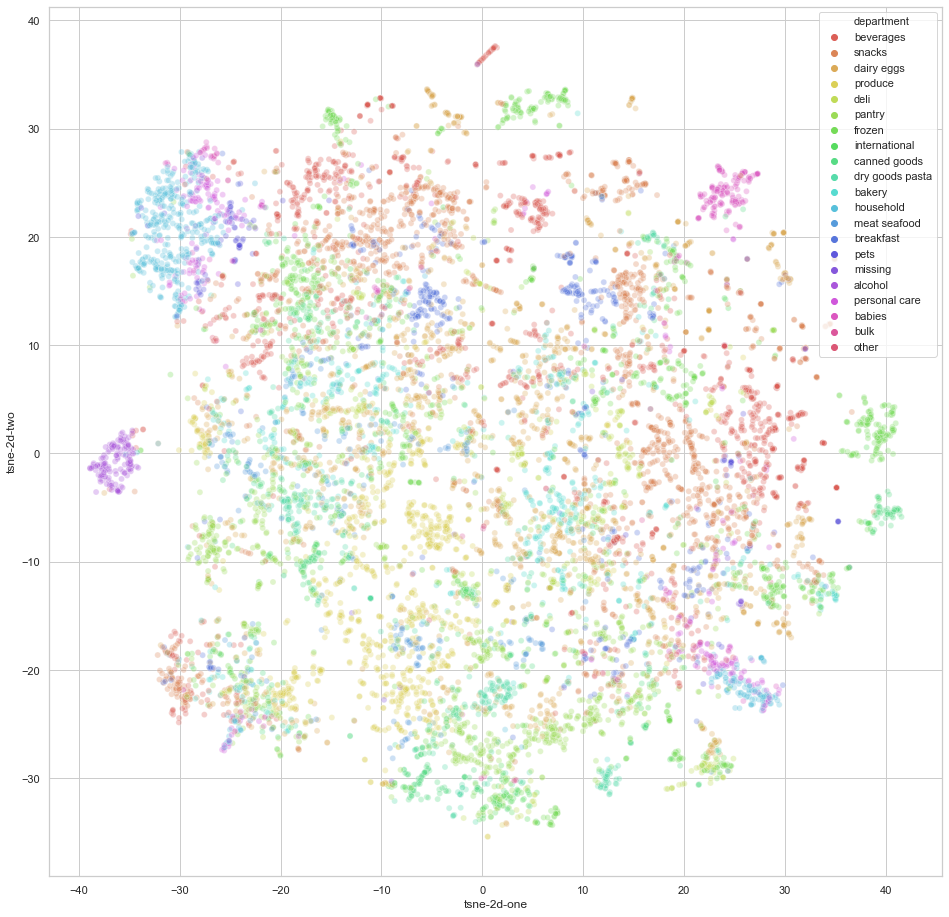

In [53]:
# visualize the entire semantic space and its mapping to the departments
plt.figure(figsize=(16, 16))
sns.set_style("whitegrid")
splot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='department',
    palette=sns.color_palette("hls", n_department),
    data=df_semantic_item,
    legend="full",
    alpha=0.3
)
splot.figure.savefig("item_space_tsne.png")
plt.show()

Products in the selected aisles: 2706


<Figure size 1440x576 with 0 Axes>

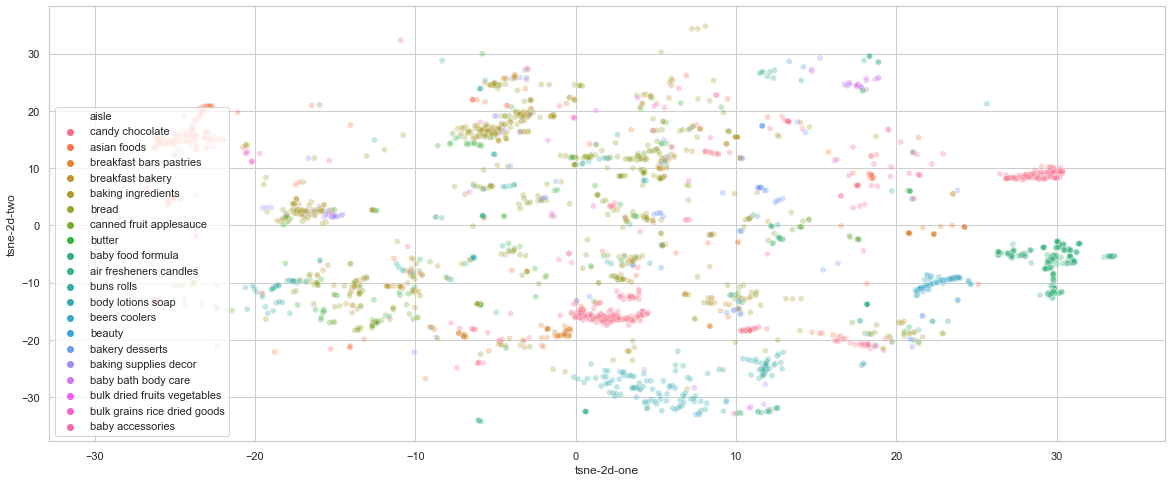

In [20]:
# visualize the mapping between the semantic space and aisles
aisle_list = sorted(df_semantic_item['aisle'].unique())
aisle_set = aisle_list[:20]   # take a subset of aisles to keep it readable

print(f'Products in the selected aisles: {df_semantic_item[df_semantic_item.aisle.isin(aisle_set)].shape[0]}')
plt.figure(figsize=(20, 8))
sns.scatterplot(
   x="tsne-2d-one", y="tsne-2d-two",
   hue='aisle',
   data=df_semantic_item[df_semantic_item.aisle.isin(aisle_set)],
   legend="full",
   alpha=0.3
)
plt.show()

Conslusion: The semantic space has a meaningful internal structure aligned with the typical product taxonomy (departments and aisles).

## Item2Vec, Step 4: Compare the Original Semantic Space and Its t-SNE Projection

In this section, we compare the original (200 dimensional) semantic space with its t-SNE projection.

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score

for space_name, space in {'TSNE': tsne_results, 'raw latent space': model.wv.vectors}.items():
    for entity in ['department', 'aisle']:
        silhouette_avg = silhouette_score(space, df_semantic_item[entity], metric="cosine")
        print(f"The number of unique {entity}s is {df_semantic_item[entity].nunique()} " +\
              f"and the average silhouette_score on {space_name} is : {silhouette_avg:.4}")

The number of unique departments is 21 and the average silhouette_score on TSNE is : -0.4912
The number of unique aisles is 134 and the average silhouette_score on TSNE is : -0.7124
The number of unique departments is 21 and the average silhouette_score on raw latent space is : -0.05162
The number of unique aisles is 134 and the average silhouette_score on raw latent space is : -0.1148


Conclusion: The high-dimensional semantic space is better aligned with traditional labels (department, asile) than t-SNE projection. More basic projection methods provide event worse results - the SVD projection below is not aligned with the labels at all. However, the aligment between the traditional labels and semantic space is very weak (negative silhouette scores) anyways. This does not mean that the semantic space has no meanigful structure - the structure is just different from product depertment taxonomy. We study the strucutre in mode detail in Customer2Vec model.  

<Figure size 576x576 with 0 Axes>

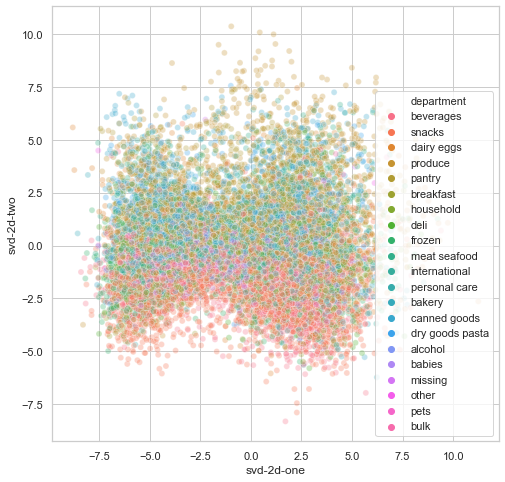

In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

df_svd = pd.DataFrame({'product_id': vocab})
df_svd['svd-2d-one'] = X_reduced[:,0]
df_svd['svd-2d-two'] = X_reduced[:,1]
df_svd['product_id'] = df_svd['product_id'].astype(int)

df_svd = df_svd.merge(data_dict['products'], on='product_id', how='left')
df_svd = df_svd.merge(data_dict['aisles'], on='aisle_id', how='left')
df_svd = df_svd.merge(data_dict['departments'], on='department_id', how='left')

plt.figure(figsize=(8, 8))
sns.scatterplot(
        x="svd-2d-one", y="svd-2d-two",
        hue='department',
        data=df_svd,
        legend="full",
        alpha=0.3
    )
plt.show()